## Method Defs

In [246]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

class InteractiveImageCropper:
    def __init__(self, image_path):
        self.original_image = Image.open(image_path)
        self.image = self.original_image.copy()
        self.img_array = np.array(self.image)
        self.rotation = 0  # Track current rotation
        
        # Create rotation radio buttons
        self.rotation_radio = widgets.RadioButtons(
            options=[('Original', 0), ('Rotated 90°', 90), ('Rotated 180°', 180), ('Rotated 270°', 270)],
            value=0,
            description='Rotation:',
            layout={'width': 'max-content'}
        )
        
        # Create widgets
        self.left_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=self.image.width,
            description='Left:',
            continuous_update=True
        )
        
        self.right_slider = widgets.IntSlider(
            value=self.image.width,
            min=0,
            max=self.image.width,
            description='Right:',
            continuous_update=True
        )
        
        self.top_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=self.image.height,
            description='Top:',
            continuous_update=True
        )
        
        self.bottom_slider = widgets.IntSlider(
            value=self.image.height,
            min=0,
            max=self.image.height,
            description='Bottom:',
            continuous_update=True
        )
        
        # Add zoom slider for cropped preview
        self.preview_zoom_slider = widgets.FloatSlider(
            value=1.0,
            min=1.0,
            max=5.0,
            step=0.1,
            description='Preview Zoom:',
            continuous_update=True
        )
        
        # Add center point for preview zoom
        self.preview_center_x = widgets.FloatSlider(
            value=0.5,
            min=0.0,
            max=1.0,
            step=0.01,
            description='Center X:',
            continuous_update=True
        )
        
        self.preview_center_y = widgets.FloatSlider(
            value=0.5,
            min=0.0,
            max=1.0,
            step=0.01,
            description='Center Y:',
            continuous_update=True
        )
        
        self.output = widgets.Output()
        
        # Layout
        self.crop_sliders = widgets.VBox([
            self.left_slider,
            self.right_slider,
            self.top_slider,
            self.bottom_slider,
        ])
        
        self.zoom_controls = widgets.VBox([
            self.preview_zoom_slider,
            self.preview_center_x,
            self.preview_center_y
        ], description='Preview Zoom Controls')
        
        # Add rotation control to layout
        self.all_controls = widgets.VBox([
            self.rotation_radio,
            widgets.HBox([self.crop_sliders, self.zoom_controls])
        ])
        
        # Link callbacks
        self.left_slider.observe(self.update_plot, names='value')
        self.right_slider.observe(self.update_plot, names='value')
        self.top_slider.observe(self.update_plot, names='value')
        self.bottom_slider.observe(self.update_plot, names='value')
        self.preview_zoom_slider.observe(self.update_plot, names='value')
        self.preview_center_x.observe(self.update_plot, names='value')
        self.preview_center_y.observe(self.update_plot, names='value')
        self.rotation_radio.observe(self.handle_rotation, names='value')
        
        # Store the current zoomed region
        self.current_zoom_bounds = None
        
        # Display initial plot
        display(widgets.VBox([self.all_controls, self.output]))
        self.update_plot(None)
        
    def handle_rotation(self, change):
        # Update rotation and recreate the image array
        self.rotation = change.new
        self.image = self.original_image.rotate(self.rotation, expand=True)
        self.img_array = np.array(self.image)
        
        # Update slider limits based on new orientation
        if self.rotation in [90, 270]:
            # Swap width and height limits
            self.left_slider.max = self.image.width
            self.right_slider.max = self.image.width
            self.top_slider.max = self.image.height
            self.bottom_slider.max = self.image.height
            
            # Reset slider values
            self.right_slider.value = self.image.width
            self.bottom_slider.value = self.image.height
            self.left_slider.value = 0
            self.top_slider.value = 0
        
        self.update_plot(None)
    
    def get_preview_zoom_limits(self, width, height):
        zoom = self.preview_zoom_slider.value
        center_x = self.preview_center_x.value
        center_y = self.preview_center_y.value
        
        # Calculate the visible region based on zoom
        visible_width = width / zoom
        visible_height = height / zoom
        
        # Calculate boundaries while keeping the center point
        left = max(0, center_x * width - visible_width/2)
        right = min(width, center_x * width + visible_width/2)
        top = max(0, center_y * height - visible_height/2)
        bottom = min(height, center_y * height + visible_height/2)
        
        return left, right, top, bottom
    
    def update_plot(self, change):
        with self.output:
            clear_output(wait=True)
            
            # Get current values
            left = self.left_slider.value
            right = self.right_slider.value
            top = self.top_slider.value
            bottom = self.bottom_slider.value
            
            # Ensure right > left and bottom > top
            if right <= left:
                right = left + 1
                self.right_slider.value = right
            if bottom <= top:
                bottom = top + 1
                self.bottom_slider.value = bottom
            
            # Create figure
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
            
            # Original image with crop rectangle
            ax1.imshow(self.img_array)
            ax1.set_title(f'Original with crop region (Rotation: {self.rotation}°)')
            rect = plt.Rectangle((left, top), right-left, bottom-top,
                               fill=False, color='red', linewidth=2)
            ax1.add_patch(rect)
            
            # Cropped image with zoom
            cropped = self.img_array[top:bottom, left:right]
            ax2.imshow(cropped)
            ax2.set_title('Cropped preview (zoomed)')
            
            # Apply zoom to preview and store the bounds
            crop_width = right - left
            crop_height = bottom - top
            left_zoom, right_zoom, top_zoom, bottom_zoom = self.get_preview_zoom_limits(
                crop_width, crop_height)
            
            # Store the current zoom bounds
            self.current_zoom_bounds = {
                'left': int(left_zoom),
                'right': int(right_zoom),
                'top': int(top_zoom),
                'bottom': int(bottom_zoom)
            }
            
            ax2.set_xlim(left_zoom, right_zoom)
            ax2.set_ylim(bottom_zoom, top_zoom)
            
            plt.tight_layout()
            plt.show()
            
            # Display current dimensions and zoom level
            print(f"Crop dimensions: {crop_width}x{crop_height} pixels")
            print(f"Preview zoom: {self.preview_zoom_slider.value:.1f}x")
            print(f"Current rotation: {self.rotation}°")
    
    def get_cropped_image(self, include_zoom=False):
        """
        Returns the cropped image as a PIL Image object.
        
        Parameters:
        include_zoom (bool): If True, returns the zoomed portion of the cropped image.
                           If False, returns the entire cropped image.
        """
        # Get the basic crop
        left = self.left_slider.value
        right = self.right_slider.value
        top = self.top_slider.value
        bottom = self.bottom_slider.value
        
        # Get the rotated and cropped image
        cropped_image = self.image.crop((left, top, right, bottom))
        
        if include_zoom and self.current_zoom_bounds is not None:
            # Apply the zoom crop
            zoom_crop = cropped_image.crop((
                self.current_zoom_bounds['left'],
                self.current_zoom_bounds['top'],
                self.current_zoom_bounds['right'],
                self.current_zoom_bounds['bottom']
            ))
            return zoom_crop
        
        return cropped_image

    
def center_crop(image, size):
    # Calculate center crop coordinates
    width, height = image.size
    new_width, new_height = size, size
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    return image.crop((left, top, right, bottom))

def create_image_grid(image_paths, output_size=(1024, 1024), inner_buffer=10):
    cropped_images = []
    
    # Open and center crop each image
    for path in image_paths:
        img = Image.open(path)
        min_side = min(img.size)  # Find the smallest side
        cropped_img = center_crop(img, min_side)  # Crop to a square
        cropped_images.append(cropped_img)
    # Calculate individual image size in the grid
    grid_size = ((output_size[0] - inner_buffer) // 2, (output_size[1] - inner_buffer) // 2)
    for i in range(len(cropped_images)):
        cropped_images[i] = cropped_images[i].resize(grid_size)

    # Create a new blank image for the 2x2 grid
    grid_image = Image.new('RGB', output_size, color='white')

    # Place each image in the grid
    grid_image.paste(cropped_images[0], (0, 0))
    grid_image.paste(cropped_images[1], (grid_size[0] + inner_buffer, 0))
    grid_image.paste(cropped_images[2], (0, grid_size[1] + inner_buffer))
    grid_image.paste(cropped_images[3], (grid_size[0] + inner_buffer, grid_size[1] + inner_buffer))

    return grid_image

## Manually Crop/Zoom GT

In [ ]:
import glob

# Code to traverse the collected ground-truth images over the entire CuRe dataset
selected_gt_root = 'selected_gt/' # directory containing selected GT images from select_gt_data.ipynb
categories = ['Architecture', 'Art', 'Celebrations',  'Fashion',  'Food',  'People']

# This code is very hacky, i.e. generate & verify GT grids one at a time on CuRe dataset
cat = categories[3]
subcats = glob.glob(f'{selected_gt_root}{cat}/*')
print([sc.split("/")[-1] for sc in subcats]) ; print()

sc = subcats[0]
items = glob.glob(f'{sc}/*')
print([(i, item.split("/")[-1]) for i, item in enumerate(items)]) ; print()

selected_item = items[12]
selected_gt_images = [f'{selected_item}/{selected_item.split("/")[-1]}-gt{i+1}.jpg' for i in range(4)]
print(selected_gt_images) ; print()

image_to_fix = selected_gt_images[3]
print(image_to_fix)
image_path = f"{image_to_fix}"  # Replace with your image path

grid_gt_images = create_image_grid(selected_gt_images)
display(grid_gt_images)

In [248]:
# Play around with sliders and zoom until satisfied with the cropped preview
new_image_path = image_path.replace(".jpg", "_temp.jpg")
cropper = InteractiveImageCropper(image_path)

In [249]:
# Save the cropped preview
zoomed_crop = cropper.get_cropped_image(include_zoom=True)
zoomed_crop.save(new_image_path) # replace this with image_path once you're satisfied

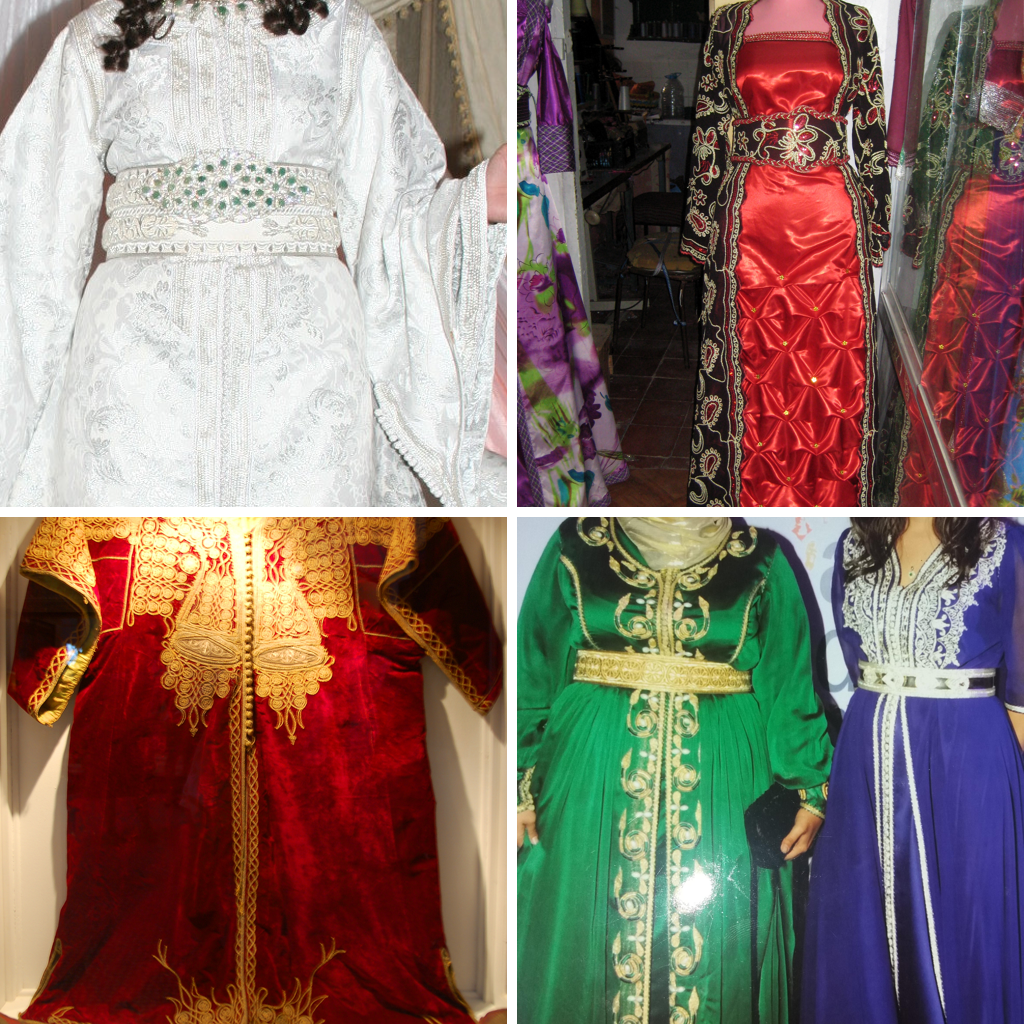

In [250]:
selected_gt_images = list(map(lambda x: x.replace(image_path, new_image_path), selected_gt_images))
grid_gt_images = create_image_grid(selected_gt_images)
display(grid_gt_images)

In [251]:
# if you're satisfied with the grid, run the cell below

In [252]:
os.rename(new_image_path, image_path)